In [ ]:
''' create dataset, 
select random n characters from a unicode range
create images from selected characters, these will be used in minibatches
'''

import numpy as np
from PIL import ImageFont, ImageDraw, Image
from skimage.color import rgb2gray

def image_from_txt(txt, x, y, binary_img = True):
    font_file = r"c:\windows\fonts\code2000.ttf"
    image = Image.new("RGBA", (x, y), (255,255,255))
    draw = ImageDraw.Draw(image)
    
    # try to fit the text perfectly to image (scale)
    fontsize = 1

    font = ImageFont.truetype(font_file, fontsize)
    while font.getsize(txt)[0] < image.size[0] and font.getsize(txt)[1] < image.size[1]:
        fontsize += 1
        font = ImageFont.truetype(font_file, fontsize)

    font = ImageFont.truetype(font_file, fontsize)
    
    horiz_pos = (x - font.getsize(txt)[0])/2
    vert_pos = (y - font.getsize(txt)[1])/2 - y/10

    draw.text((horiz_pos, vert_pos), txt, font=font, fill = (0,0,0))
    
    result = rgb2gray(np.array(image))[:, :, np.newaxis]

    # easier to train without grays
    if binary_img:
        result[result >= .3] = 1
        result[result < .3] = 0
    
    # randomly flip images to artifically create more data
    if np.random.rand() < 0.2:
        return np.fliplr(result)
    return result

unicode_range = [
    (0x3400, 0x4dbf), # CJK unified ideographs (Common and Uncommon Kanji)
    (0x4e00, 0x9faf) # CJK unified ideographs extension A (Rare Kanji)
]

available_chars = [c for r in unicode_range for c in range(r[0], r[1]+1)]
n_chars = len(available_chars)

def get_random_kanji_image(n=1, x=64, y=64):
    # randomly select kanjis within a range
    kanji_ranges = [chr(c) for c in np.random.choice(available_chars, n)]
    
    # create normalized numpy arrays from selected kanjis
    return np.asarray([image_from_txt(txt, x ,y) for txt in kanji_ranges])

<IPython.core.display.Javascript object>


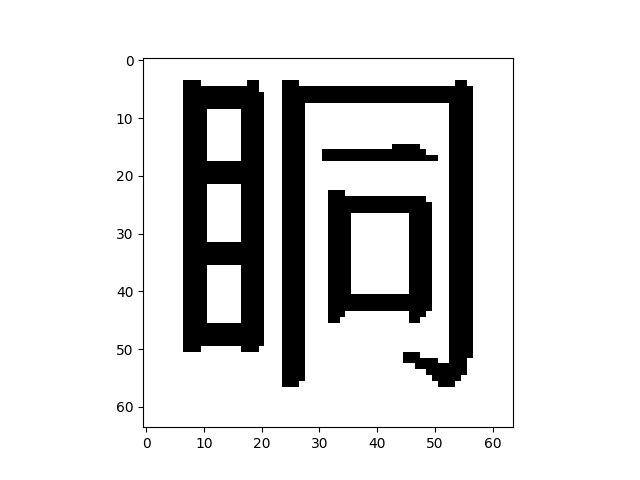

In [2]:
# check images are correctly created
%matplotlib notebook
import matplotlib.pyplot as plt

image = get_random_kanji_image().squeeze()
fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")

In [ ]:
from keras.models import (Sequential)
from keras.layers.normalization import BatchNormalization
from keras.layers.core import (Reshape, Dense, Flatten, Activation)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (Conv2D, Conv2DTranspose)
from keras.optimizers import Adam
from keras.utils import plot_model


# Set network & training parameters
learning_rate = 0.0002
batch_size = 64
n_training_samples = n_chars/100
training_epochs = 25 - 22
display_step = 1

output_folder = 'results/'

# Build generator model
g = Sequential()

# 100 -> 8192 (4*4 is because of 4 deconvolutions to reach 64)
g.add(Dense(input_dim=100, units=64*8*4*4))
g.add(BatchNormalization())
g.add(LeakyReLU())

# 8192 -> (4 x 4 x 512)
g.add(Reshape((4, 4, 512)))

# (4 x 4 x 512) -> (8 x 8 x 256)
g.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"))
g.add(BatchNormalization())
g.add(LeakyReLU())

# (8 x 8 x 256) -> (16 x 16 x 128)
g.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"))
g.add(BatchNormalization())
g.add(LeakyReLU())

# (16 x 16 x 128) -> (32 x 32 x 64)
g.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"))
g.add(BatchNormalization())
g.add(LeakyReLU())

# (32 x 32 x 64) -> (64 x 64 x 1)
g.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same"))
g.add(Activation('tanh'))


# Build discriminator model
d = Sequential()

# (64 x 64 x 1) -> (32 x 32 x 64)
d.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(64, 64, 1)))
d.add(LeakyReLU(alpha=.2))

# (32 x 32 x 64) -> (16 x 16 x 128)
d.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
d.add(BatchNormalization())
d.add(LeakyReLU(alpha=.2))

# (16 x 16 x 128) -> (8 x 8 x 256)
d.add(Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
d.add(BatchNormalization())
d.add(LeakyReLU(alpha=.2))

# (8 x 8 x 256) -> (4 x 4 x 512)
d.add(Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
d.add(BatchNormalization())
d.add(LeakyReLU(alpha=.2))

# (4 x 4 x 512) -> 8192
d.add(Flatten())

# 8192 -> 1
d.add(Dense(1))
d.add(Activation('sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate))
d.trainable = False


# Combine models -> pred = discriminator(generator(input_noise))
model = Sequential()
model.add(g)
model.add(d)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate))

# save model graphs to disk
plot_model(g, to_file=output_folder + 'model_generator.png', show_shapes=True)
plot_model(d, to_file=output_folder + 'model_discriminator.png', show_shapes=True)
plot_model(model, to_file=output_folder + 'model.png', show_shapes=True)


model_stats = {'d_loss': [], 'g_loss': []}     
for epoch in range(training_epochs):
    total_batches = int(n_training_samples/batch_size);
    avg_d_loss, avg_g_loss = 0, 0
    for i in range(total_batches):
        print("Epoch({}) - {}/{} | ".format(epoch, i+1,total_batches) + 
              "#" * round((i+1)*100/total_batches) + 
              "-" * round((total_batches-(i+1))*100/total_batches) + 
              " |", end="\r")
        
        # Generate images
        input_img = get_random_kanji_image(batch_size)
        input_noise = np.random.normal(0, 1, (batch_size, 100))
        generated_img = g.predict(input_noise)
        
        x_d = np.concatenate([input_img, generated_img])
        y_d = np.zeros(batch_size*2)
        y_d[:batch_size] = 1
        
        # shuffle training set
        p = np.random.permutation(batch_size*2)
        x_d, y_d = x_d[p], y_d[p]
        
        # Train discriminator model
        avg_d_loss += d.train_on_batch(x_d, y_d) / total_batches
        
        # Train generator model
        noise = np.random.normal(0, 1, (batch_size, 100))
        y_g = np.ones(batch_size)
        
        avg_g_loss += model.train_on_batch(noise, y_g) / total_batches
    
    model_stats['g_loss'].append(avg_g_loss)
    model_stats['d_loss'].append(avg_d_loss)
    
    # display epoch results
    if epoch % display_step == 0:
        print("\n\tEpoch({}) - avg discriminator loss: {:.10f}, avg generator loss: {:.10f}"
              .format(epoch, avg_d_loss, avg_g_loss))
        
        # save intermediate epoch results to file
        epoch_results = np.squeeze(g.predict(np.random.normal(0, 1, (4, 100))))
        epoch_results[epoch_results >= 0] = 1
        epoch_results[epoch_results < 0] = 0
        epoch_results *= 255
        
        im = Image.fromarray(np.hstack(epoch_results)).convert("RGB")
        im.save(output_folder + "epoch_{}.jpg".format(epoch))


# plot loss curves
fig, ax = plt.subplots()

ax.plot(model_stats['g_loss'], c='r', linestyle='-', label='Generator')
ax.plot(model_stats['d_loss'], c='b', linestyle='--', label='Discriminator')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('DCGAN - Keras Training Results')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# plot final image generation results
n_examples = (4, 4)

noise = np.random.normal(0, 1, (n_examples[0] * n_examples[1], 100))
result = g.predict(noise)

result[result >= 0] = 1
result[result < 0] = 0

fig, axs = plt.subplots(*n_examples)

i=0
for ax in axs.flat:
    ax.imshow(np.squeeze(result[i]), cmap="gray")
    ax.tick_params(bottom='off', top='off', left='off', right='off', 
                   labelbottom='off', labelleft='off')
    i+=1
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()